In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Conv1D, Dropout
from tensorflow import keras
from tensorflow.keras import layers, models
from skimage import color
from skimage import filters
import tensorflow as tf

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [2]:
# Choose the label type
Labeltype = 'age'

In [3]:
# Import image labels and paths to dataframe
mypath = "C:/Users/User/Desktop/CUNY/Faces_img/cropped.tar/cropped/crop_part1"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath +'/'+ x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.3, random_state=42)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 10000
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(5000/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples)).sample(frac=1)

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets (Total should be 10000)
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=2, n=1399 (11.111%)
Class=7, n=1399 (11.111%)
Class=1, n=1399 (11.111%)
Class=4, n=1399 (11.111%)
Class=5, n=1399 (11.111%)
Class=8, n=1399 (11.111%)
Class=3, n=1399 (11.111%)
Class=6, n=1399 (11.111%)
Class=0, n=1399 (11.111%)
Class=7, n=555 (11.111%)
Class=2, n=555 (11.111%)
Class=8, n=555 (11.111%)
Class=4, n=555 (11.111%)
Class=3, n=555 (11.111%)
Class=1, n=555 (11.111%)
Class=0, n=555 (11.111%)
Class=5, n=555 (11.111%)
Class=6, n=555 (11.111%)


In [4]:
dfbalancedsubset.head()

,file,label
2663,C:/Users/User/Desktop/CUNY/Faces_img/cropped.t...,7
8106,C:/Users/User/Desktop/CUNY/Faces_img/cropped.t...,2
11713,C:/Users/User/Desktop/CUNY/Faces_img/cropped.t...,8
9098,C:/Users/User/Desktop/CUNY/Faces_img/cropped.t...,2
10691,C:/Users/User/Desktop/CUNY/Faces_img/cropped.t...,4


In [5]:
# Get training images
train_img_container = []
for i in dfbalancedsubset['file']:
    img = cv2.imread(i)
    train_img_container.append(img)
train_img_container = np.array(train_img_container)

In [6]:
train_img_container.shape

(4995, 200, 200, 3)

In [11]:
nimages, nX, ny, nrgb = train_img_container.shape
train_img_container = train_img_container.reshape((nimages,nX*ny*nrgb))

In [9]:
lr_age=LogisticRegression()

In [12]:
lr_age.fit(train_img_container, dfbalancedsubset['label'])

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [13]:
prediction=lr_age.predict(train_img_container)

In [16]:
print(f"accuracy: {accuracy_score(dfbalancedsubset['label'], prediction)}")
print(f"{classification_report(dfbalancedsubset['label'], prediction)}")

accuracy: 0.7039039039039039
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       555
           1       0.67      0.73      0.70       555
           2       0.73      0.69      0.71       555
           3       0.72      0.76      0.74       555
           4       0.64      0.60      0.62       555
           5       0.61      0.61      0.61       555
           6       0.63      0.64      0.63       555
           7       0.66      0.62      0.64       555
           8       0.83      0.85      0.84       555

    accuracy                           0.70      4995
   macro avg       0.70      0.70      0.70      4995
weighted avg       0.70      0.70      0.70      4995



In [19]:
# Get testing images
test_img_container = []
for i in X_test:
    img = cv2.imread(i)
    test_img_container.append(img)
test_img_container = np.array(test_img_container)

In [22]:
nimages, nX, ny, nrgb = test_img_container.shape
test_img_container = test_img_container.reshape((nimages,nX*ny*nrgb))

In [25]:
pred_test=lr_age.predict(test_img_container)

In [26]:
print(f"accuracy: {accuracy_score(y_test, pred_test)}")
print(f"{classification_report(y_test, pred_test)}")

accuracy: 0.4614860259032038
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       480
           1       0.30      0.42      0.35       216
           2       0.32      0.27      0.29       157
           3       0.22      0.36      0.27       118
           4       0.37      0.40      0.38       341
           5       0.55      0.43      0.48       616
           6       0.32      0.38      0.35       354
           7       0.53      0.43      0.47       537
           8       0.34      0.53      0.41       115

    accuracy                           0.46      2934
   macro avg       0.42      0.44      0.42      2934
weighted avg       0.49      0.46      0.47      2934



In [28]:
mean_squared_error(dfbalancedsubset['label'], prediction)

1.4906906906906907

In [29]:
mean_absolute_error(dfbalancedsubset['label'], prediction)

0.5357357357357357

In [35]:
# Compute confusion matrix
cm_age = metrics.confusion_matrix(y_test, pred_test)

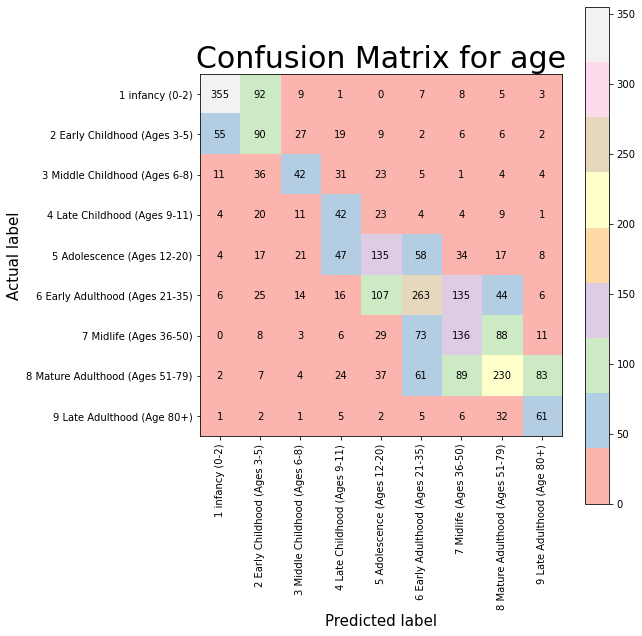

In [36]:
plt.figure(figsize=(9,9))
plt.imshow(cm_age, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix for age', size = 30)
plt.colorbar()
tick_marks = np.arange(9)
plt.xticks(tick_marks, ["1 infancy (0-2)", "2 Early Childhood (Ages 3-5)", "3 Middle Childhood (Ages 6-8)", "4 Late Childhood (Ages 9-11)", "5 Adolescence (Ages 12-20)", "6 Early Adulthood (Ages 21-35)", "7 Midlife (Ages 36-50)", "8 Mature Adulthood (Ages 51-79)", "9 Late Adulthood (Age 80+)"], rotation=90, size = 10)
plt.yticks(tick_marks, ["1 infancy (0-2)", "2 Early Childhood (Ages 3-5)", "3 Middle Childhood (Ages 6-8)", "4 Late Childhood (Ages 9-11)", "5 Adolescence (Ages 12-20)", "6 Early Adulthood (Ages 21-35)", "7 Midlife (Ages 36-50)", "8 Mature Adulthood (Ages 51-79)", "9 Late Adulthood (Age 80+)"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm_age.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm_age[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '1 infancy (0-2)'),
  Text(0, 1, '2 Early Childhood (Ages 3-5)'),
  Text(0, 2, '3 Middle Childhood (Ages 6-8)'),
  Text(0, 3, '4 Late Childhood (Ages 9-11)'),
  Text(0, 4, '5 Adolescence (Ages 12-20)'),
  Text(0, 5, '6 Early Adulthood (Ages 21-35)'),
  Text(0, 6, '7 Midlife (Ages 36-50)'),
  Text(0, 7, '8 Mature Adulthood (Ages 51-79)'),
  Text(0, 8, '9 Late Adulthood (Age 80+)')])

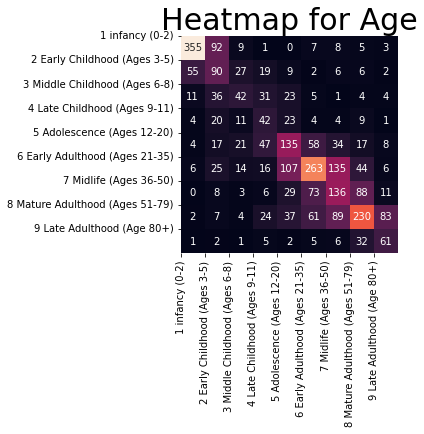

In [41]:
sns.heatmap(cm_age, square = True, annot=True, fmt = 'd', cbar = False)
plt.title('Heatmap for Age', size = 30)
tick_marks = np.arange(9)
plt.xticks(tick_marks, ["1 infancy (0-2)", "2 Early Childhood (Ages 3-5)", "3 Middle Childhood (Ages 6-8)", "4 Late Childhood (Ages 9-11)", "5 Adolescence (Ages 12-20)", "6 Early Adulthood (Ages 21-35)", "7 Midlife (Ages 36-50)", "8 Mature Adulthood (Ages 51-79)", "9 Late Adulthood (Age 80+)"], rotation=90, size = 10)
plt.yticks(tick_marks, ["1 infancy (0-2)", "2 Early Childhood (Ages 3-5)", "3 Middle Childhood (Ages 6-8)", "4 Late Childhood (Ages 9-11)", "5 Adolescence (Ages 12-20)", "6 Early Adulthood (Ages 21-35)", "7 Midlife (Ages 36-50)", "8 Mature Adulthood (Ages 51-79)", "9 Late Adulthood (Age 80+)"], size = 10)
plt.yticks(rotation=0) 
